<a href="https://colab.research.google.com/github/LiQuinChing/25-26J-522/blob/Detection-of-Arrhythmia-vihara/PerRecLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb seaborn scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

WINDOW_SIZE = 500          # 500 samples per segment
SEGMENTS_PER_RECORD = 10   # max segments per record
CHANNEL = 0                # first ECG channel (for WFDB)


In [ ]:
import glob

def list_wfdb_records(base_dir):
    """
    Return a sorted list of record names (without extension)
    for all .dat files in base_dir.
    """
    dat_files = glob.glob(os.path.join(base_dir, "*.dat"))
    rec_names = sorted(os.path.splitext(os.path.basename(f))[0] for f in dat_files)
    return rec_names


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ARR: CSV only
arr_dir_csv = "/content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive"

# NSR MIT-BIH: .hea + .dat + .atr
nsr_base_dir_mit = "/content/drive/MyDrive/Datasets/MIT-BIH normal sinus rhythm/mit-bih-normal-sinus-rhythm-database-1.0.0/mit-bih-normal-sinus-rhythm-database-1.0.0"

# NSR Kaggle: .hea + .mat (assume WFDB can read; likely no .atr)
nsr_base_dir_kaggle = "/content/drive/MyDrive/Datasets/Kaggle sinus rhythm usability"


In [ ]:
def list_wfdb_records(base_dir, exts=(".dat", ".mat")):
    """
    Return a sorted list of record names (without extension) for WFDB-style files.
    We accept either .dat or .mat paired with .hea.
    """
    rec_names = set()
    for ext in exts:
        files = glob.glob(os.path.join(base_dir, f"*{ext}"))
        for f in files:
            rec_names.add(os.path.splitext(os.path.basename(f))[0])
    return sorted(rec_names)


In [ ]:
# ARR CSV files
arr_csv_files = sorted(glob.glob(os.path.join(arr_dir_csv, "*.csv")))
print("ARR CSV files:", len(arr_csv_files))

# NSR MIT WFDB
nsr_mit_records = list_wfdb_records(nsr_base_dir_mit, exts=(".dat",))
print("MIT NSR records:", nsr_mit_records)

# NSR Kaggle WFDB-style (likely .mat + .hea)
nsr_kaggle_records = list_wfdb_records(nsr_base_dir_kaggle, exts=(".mat",))
print("Kaggle NSR records:", nsr_kaggle_records)

# Combine NSR as (base_dir, rec_name)
nsr_records_all = []
for rec in nsr_mit_records:
    nsr_records_all.append((nsr_base_dir_mit, rec, "mit"))
for rec in nsr_kaggle_records:
    nsr_records_all.append((nsr_base_dir_kaggle, rec, "kaggle"))

print("Total NSR records:", len(nsr_records_all))


ARR CSV files: 48
MIT NSR records: ['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453', '18177', '18184', '19088', '19090', '19093', '19140', '19830']
Kaggle NSR records: ['A0002', 'A0016', 'A0020', 'A0029', 'A0030', 'A0037', 'A0038', 'A0041', 'A0059', 'A0073', 'A0075', 'A0089', 'A0090', 'A0094', 'A0107', 'A0125', 'A0133', 'A0141', 'A0143', 'A0149', 'A0157', 'A0164', 'A0166', 'A0170', 'A0173', 'A0175', 'A0176', 'A0177', 'A0179', 'A0189', 'A0190', 'A0192', 'A0193', 'A0206', 'A0208', 'A0210', 'A0221', 'A0229']
Total NSR records: 56


In [ ]:
# We will use these leads if present
PREFERRED_LEADS = ["MLII", "V5", 'V2', 'V1', 'II', 'III', 'aVR', 'aVL', 'aVF']

def list_arr_recordings_from_csv(arr_csv_files):
    """
    Build a list of (csv_path, preferred_lead) combinations.
    We'll treat each (file, lead) as one 'record'.
    """
    recordings = []
    for csv_path in arr_csv_files:
        df = pd.read_csv(csv_path, nrows=1)  # peek columns
        cols = list(df.columns)

        for lead in PREFERRED_LEADS:
            if lead in cols:
                recordings.append((csv_path, lead))
    return recordings

arr_recordings = list_arr_recordings_from_csv(arr_csv_files)
print("ARR recordings (CSV+lead):", len(arr_recordings))


ARR recordings (CSV+lead): 95


In [ ]:
# Normal beats (for MIT NSR annotations)
NORMAL_SYMBOLS = ["N"]


In [ ]:
def split_recordings(rec_list, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    """
    Split a list into train/val/test subsets.
    """
    rec_list = rec_list.copy()
    random.shuffle(rec_list)
    n = len(rec_list)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = rec_list[:n_train]
    val   = rec_list[n_train:n_train + n_val]
    test  = rec_list[n_train + n_val:]
    return train, val, test


7. Segment helpers
7.1 Uniform segmentation for ARR CSV and NSR Kaggle

In [ ]:
def segment_signal_uniform(signal, window_size=WINDOW_SIZE, max_segments=SEGMENTS_PER_RECORD):
    """
    Cut a long 1D signal into non-overlapping windows of length window_size,
    then randomly sample up to max_segments windows.
    """
    signal = np.asarray(signal, dtype="float32")
    total_len = len(signal)
    n_full = total_len // window_size
    if n_full == 0:
        return np.empty((0, window_size), dtype="float32")

    # all contiguous windows
    all_segs = []
    for i in range(n_full):
        start = i * window_size
        end = start + window_size
        all_segs.append(signal[start:end])
    all_segs = np.stack(all_segs, axis=0)

    if all_segs.shape[0] > max_segments:
        idx = np.random.choice(all_segs.shape[0], size=max_segments, replace=False)
        all_segs = all_segs[idx]

    return all_segs


7.2 Segments around normal beats for MIT NSR (.atr)

In [ ]:
def extract_nsr_segments_with_annotations(base_dir, rec_name,
                                          window_size=WINDOW_SIZE,
                                          max_segments=SEGMENTS_PER_RECORD,
                                          channel=CHANNEL):
    """
    Extract NSR segments from MIT NSR using annotations: segments around 'N' beats.
    """
    rec_path = os.path.join(base_dir, rec_name)
    dat_path = rec_path + ".dat"
    hea_path = rec_path + ".hea"
    atr_path = rec_path + ".atr"

    if not (os.path.exists(dat_path) and os.path.exists(hea_path) and os.path.exists(atr_path)):
        print(f"Warning: missing WFDB files for MIT NSR record {rec_name}, skipping annotations.")
        return np.empty((0, window_size), dtype="float32")

    record = wfdb.rdrecord(rec_path)
    ann = wfdb.rdann(rec_path, 'atr')

    signal = record.p_signal[:, channel].astype("float32")
    samples = np.array(ann.sample)
    symbols = np.array(ann.symbol)

    idxs = np.where(np.isin(symbols, NORMAL_SYMBOLS))[0]
    if len(idxs) == 0:
        return np.empty((0, window_size), dtype="float32")

    beat_positions = samples[idxs]
    if len(beat_positions) > max_segments:
        beat_positions = np.random.choice(beat_positions, size=max_segments, replace=False)

    segments = []
    half = window_size // 2
    length = len(signal)

    for pos in beat_positions:
        start = int(pos) - half
        end = start + window_size

        if start < 0:
            start = 0
            end = window_size
        if end > length:
            end = length
            start = end - window_size

        seg = signal[start:end]
        if len(seg) == window_size:
            segments.append(seg)

    if len(segments) == 0:
        return np.empty((0, window_size), dtype="float32")

    return np.stack(segments, axis=0)


8. ARR builder (from CSV)

In [ ]:
def build_arr_segments_split(arr_recordings_subset,
                             window_size=WINDOW_SIZE,
                             max_segments_per_record=SEGMENTS_PER_RECORD):
    """
    Build (X_arr, y_arr, rec_ids_arr) for ARR from CSV + leads.
    """
    X, y, rec_ids = [], [], []

    for csv_path, lead in arr_recordings_subset:
        df = pd.read_csv(csv_path)
        if lead not in df.columns:
            # skip if lead disappeared for some reason
            continue

        signal = df[lead].values.astype("float32")
        segs = segment_signal_uniform(signal, window_size, max_segments_per_record)

        rec_name = os.path.splitext(os.path.basename(csv_path))[0]
        rec_id = f"ARR_{rec_name}_{lead}"

        for seg in segs:
            X.append(seg)
            y.append(1)          # ARR label
            rec_ids.append(rec_id)

    if not X:
        return (np.empty((0, window_size, 1), dtype="float32"),
                np.empty((0,), dtype="int32"),
                np.array([], dtype=str))

    X = np.array(X, dtype="float32")
    y = np.array(y, dtype="int32")
    rec_ids = np.array(rec_ids, dtype=str)

    # add channel dimension (N, 500, 1)
    X = X[..., np.newaxis]
    return X, y, rec_ids


9. NSR builder (MIT + Kaggle)

In [ ]:
def build_nsr_segments_split(nsr_records_subset,
                             window_size=WINDOW_SIZE,
                             max_segments_per_record=SEGMENTS_PER_RECORD):
    """
    Build (X_nsr, y_nsr, rec_ids_nsr) for NSR from MIT (.dat/.atr) and Kaggle (.mat without .atr).
    """
    X, y, rec_ids = [], [], []

    for base_dir, rec_name, src in nsr_records_subset:
        rec_path = os.path.join(base_dir, rec_name)

        # Try MIT NSR with annotations
        if src == "mit":
            segs = extract_nsr_segments_with_annotations(
                base_dir, rec_name,
                window_size=window_size,
                max_segments=max_segments_per_record,
                channel=CHANNEL
            )
            # If annotation path fails or no beats, fallback to uniform
            if segs.shape[0] == 0:
                record = wfdb.rdrecord(rec_path)
                signal = record.p_signal[:, CHANNEL].astype("float32")
                segs = segment_signal_uniform(signal, window_size, max_segments_per_record)

            rec_id = f"NSR_MIT_{rec_name}"

        else:  # "kaggle"
            # There might be .mat + .hea, probably no .atr → treat as continuous NSR
            # WFDB should handle .mat with matching .hea
            record = wfdb.rdrecord(rec_path)
            signal = record.p_signal[:, CHANNEL].astype("float32")
            segs = segment_signal_uniform(signal, window_size, max_segments_per_record)
            rec_id = f"NSR_KAG_{rec_name}"

        for seg in segs:
            X.append(seg)
            y.append(0)              # NSR label
            rec_ids.append(rec_id)

    if not X:
        return (np.empty((0, window_size, 1), dtype="float32"),
                np.empty((0,), dtype="int32"),
                np.array([], dtype=str))

    X = np.array(X, dtype="float32")
    y = np.array(y, dtype="int32")
    rec_ids = np.array(rec_ids, dtype=str)

    X = X[..., np.newaxis]
    return X, y, rec_ids


10. Split recordings and build raw datasets

In [ ]:
# Split ARR and NSR recordings
arr_train_recs, arr_val_recs, arr_test_recs = split_recordings(arr_recordings)
nsr_train_recs, nsr_val_recs, nsr_test_recs = split_recordings(nsr_records_all)

print("ARR train/val/test:", len(arr_train_recs), len(arr_val_recs), len(arr_test_recs))
print("NSR train/val/test:", len(nsr_train_recs), len(nsr_val_recs), len(nsr_test_recs))

# Build ARR + NSR for each split
X_arr_train_raw, y_arr_train, rec_ids_arr_train = build_arr_segments_split(arr_train_recs)
X_nsr_train_raw, y_nsr_train, rec_ids_nsr_train = build_nsr_segments_split(nsr_train_recs)

X_arr_val_raw, y_arr_val, rec_ids_arr_val = build_arr_segments_split(arr_val_recs)
X_nsr_val_raw, y_nsr_val, rec_ids_nsr_val = build_nsr_segments_split(nsr_val_recs)

X_arr_test_raw, y_arr_test, rec_ids_arr_test = build_arr_segments_split(arr_test_recs)
X_nsr_test_raw, y_nsr_test, rec_ids_nsr_test = build_nsr_segments_split(nsr_test_recs)

# Concatenate ARR + NSR for each split
X_train_raw = np.concatenate([X_arr_train_raw, X_nsr_train_raw], axis=0)
y_train = np.concatenate([y_arr_train, y_nsr_train], axis=0)
rec_ids_train = np.concatenate([rec_ids_arr_train, rec_ids_nsr_train], axis=0)

X_val_raw = np.concatenate([X_arr_val_raw, X_nsr_val_raw], axis=0)
y_val = np.concatenate([y_arr_val, y_nsr_val], axis=0)
rec_ids_val = np.concatenate([rec_ids_arr_val, rec_ids_nsr_val], axis=0)

X_test_raw = np.concatenate([X_arr_test_raw, X_nsr_test_raw], axis=0)
y_test = np.concatenate([y_arr_test, y_nsr_test], axis=0)
rec_ids_test = np.concatenate([rec_ids_arr_test, rec_ids_nsr_test], axis=0)

print("Raw TRAIN:", X_train_raw.shape, y_train.shape)
print("Raw VAL:  ", X_val_raw.shape,   y_val.shape)
print("Raw TEST: ", X_test_raw.shape,  y_test.shape)

print("Train class counts → NSR(0):", np.sum(y_train == 0), "ARR(1):", np.sum(y_train == 1))
print("Val   class counts → NSR(0):", np.sum(y_val == 0),   np.sum(y_val == 1))
print("Test  class counts → NSR(0):", np.sum(y_test == 0),  np.sum(y_test == 1))


ARR train/val/test: 57 19 19
NSR train/val/test: 33 11 12
Raw TRAIN: (900, 500, 1) (900,)
Raw VAL:   (300, 500, 1) (300,)
Raw TEST:  (310, 500, 1) (310,)
Train class counts → NSR(0): 330 ARR(1): 570
Val   class counts → NSR(0): 110 190
Test  class counts → NSR(0): 120 190


11. Normalise using train stats (z-score)

In [ ]:
train_mean = X_train_raw.mean()
train_std  = X_train_raw.std() + 1e-8

X_train = (X_train_raw - train_mean) / train_std
X_val   = (X_val_raw   - train_mean) / train_std
X_test  = (X_test_raw  - train_mean) / train_std

print("After normalisation:")
print("Train mean ~", X_train.mean(), "std ~", X_train.std())


After normalisation:
Train mean ~ -1.312934e-07 std ~ 0.9999998


12. LSTM model (2.3.2 style)

In [ ]:
y_train = y_train.astype("int32")
y_val   = y_val.astype("int32")
y_test  = y_test.astype("int32")


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

tf.keras.backend.clear_session()  # reset graph, avoid leftover state

def build_lstm_section_232(input_len=500,
                           n_channels=1,
                           n_classes=2,
                           lstm_units=128,
                           fc1_units=128,
                           fc2_units=64,
                           fc3_units=32,
                           dropout_rate=0.5,
                           lr=1e-3):
    model = Sequential([
        Input(shape=(input_len, n_channels)),

        LSTM(lstm_units, return_sequences=False),

        Dense(fc1_units, activation='relu'),
        Dropout(dropout_rate),

        Dense(fc2_units, activation='relu'),
        Dropout(dropout_rate),

        Dense(fc3_units, activation='relu'),
        Dropout(dropout_rate),

        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
         metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
    )
    return model

model_lstm = build_lstm_section_232(
    input_len=WINDOW_SIZE,
    n_channels=1,
    n_classes=2,
    lstm_units=128,
    fc1_units=128,
    fc2_units=64,
    fc3_units=32,
    dropout_rate=0.5,
    lr=1e-3
)

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,474 (365.13 KB)

 Trainable params: 93,474 (365.13 KB)

 Non-trainable params: 0 (0.00 B)

13. Train

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    shuffle=True
)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - accuracy: 0.5515 - loss: 0.6544 - val_accuracy: 0.6333 - val_loss: 0.5474
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 604ms/step - accuracy: 0.6491 - loss: 0.5158 - val_accuracy: 0.8067 - val_loss: 0.4994
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 604ms/step - accuracy: 0.7267 - loss: 0.5104 - val_accuracy: 0.7167 - val_loss: 0.5147
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 852ms/step - accuracy: 0.7331 - loss: 0.4906 - val_accuracy: 0.7667 - val_loss: 0.4679
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 613ms/step - accuracy: 0.7355 - loss: 0.5355 - val_accuracy: 0.6133 - val_loss: 0.6517
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 634ms/step - accuracy: 0.7122 - loss: 0.5746 - val_accuracy: 0.8400 - val_loss: 0.5039
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 607ms/step - accuracy: 0.8168 - loss: 0.5661 - val_accuracy: 0.8167 - val_loss: 0.4444
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 635ms/step - accuracy: 0.8215 - loss: 0.4280 - val_accu

Segment-level test performance:

In [ ]:
from sklearn.metrics import roc_auc_score

# segment-level AUC
probs_test = model_lstm.predict(X_test, verbose=0)[:, 1]  # probability of ARR (class 1)
auc_seg = roc_auc_score(y_test, probs_test)
print("Segment-level AUC:", auc_seg)


Segment-level AUC: 0.9064912280701755


14. Per-record evaluation

LSTM per-record ARR vs NSR (test set)
Number of recordings: 31
              precision    recall  f1-score   support

         NSR       0.85      0.92      0.88        12
         ARR       0.94      0.89      0.92        19

    accuracy                           0.90        31
   macro avg       0.90      0.91      0.90        31
weighted avg       0.91      0.90      0.90        31



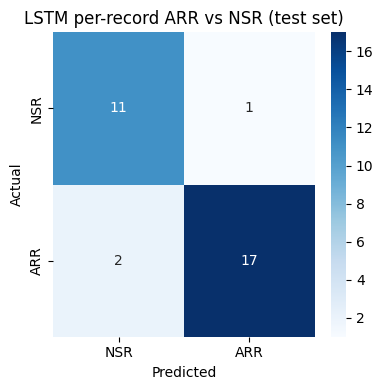

In [ ]:
def evaluate_per_record(model, X_segments, y_segments, record_ids, title="Per-record evaluation"):
    probs = model.predict(X_segments, verbose=0)  # (N_segments, 2)

    unique_records = np.unique(record_ids)
    rec_true = []
    rec_pred = []

    for rec in unique_records:
        mask = (record_ids == rec)
        rec_probs = probs[mask].mean(axis=0)
        pred_class = int(np.argmax(rec_probs))

        true_label = int(np.round(y_segments[mask].mean()))
        rec_true.append(true_label)
        rec_pred.append(pred_class)

    rec_true = np.array(rec_true, dtype="int32")
    rec_pred = np.array(rec_pred, dtype="int32")

    print(title)
    print("Number of recordings:", len(unique_records))
    print(classification_report(rec_true, rec_pred, target_names=["NSR", "ARR"]))

    cm = confusion_matrix(rec_true, rec_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["NSR", "ARR"],
                yticklabels=["NSR", "ARR"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return rec_true, rec_pred

rec_true, rec_pred = evaluate_per_record(
    model_lstm,
    X_test, y_test, rec_ids_test,
    title="LSTM per-record ARR vs NSR (test set)"
)


15. Save model (optional)

In [ ]:
save_dir = "/content/drive/MyDrive/ECG_Models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "lstm_arr_nsr_csv_wfdb_perrecord.keras") # Changed extension to .keras
model_lstm.save(model_path)
print("Model saved to:", model_path)

Model saved to: /content/drive/MyDrive/ECG_Models/lstm_arr_nsr_csv_wfdb_perrecord.keras
